In [25]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [26]:
# Load dataset
file_path = 'nutri_score_results.csv'  # Ganti dengan path file Anda
dataset = pd.read_csv(file_path)

# Mapping target ke kategori
def map_nutri_score_to_category(nutri_score):
    if nutri_score <= 0:
        return "A"
    elif nutri_score <= 2:
        return "B"
    elif nutri_score <= 6:
        return "C"
    elif nutri_score <= 9:
        return "D"
    else:
        return "E"

dataset['nutri_category'] = dataset['nutri_score'].apply(map_nutri_score_to_category)

# Tentukan fitur dan target
X = dataset.drop(columns=['nutri_score', 'nutri_category'])  # Fitur
y = dataset['nutri_category']  # Target kategori

# Split data menjadi 80% training dan 20% testing
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Pisahkan fitur dan target
X_train = train_data.drop(columns=['nutri_score', 'nutri_category'])  # Fitur latih
y_train = train_data['nutri_category']  # Target latih
X_test = test_data.drop(columns=['nutri_score', 'nutri_category'])  # Fitur uji
y_test = test_data['nutri_category']  # Target uji

In [27]:
# Preprocessing function
def preprocess_product_name(df):
    # Extract brand (first word before underscore or space)
    df['brand'] = df['nama_produk'].apply(lambda x: re.split(r'[_ ]', x)[0].lower())
    
    # Extract product type (remaining meaningful words without numbers and special characters)
    df['product_type'] = df['nama_produk'].apply(
        lambda x: ' '.join(
            [word.lower() for word in re.findall(r'[a-zA-Z]+', x) if len(word) > 2]
        )
    )
    return df

# Preprocess train and test data
X_train_processed = preprocess_product_name(X_train.copy())
X_test_processed = preprocess_product_name(X_test.copy())

In [28]:
# One-hot encoding for 'brand' column
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_brand_encoded = one_hot_encoder.fit_transform(X_train_processed[['brand']])
test_brand_encoded = one_hot_encoder.transform(X_test_processed[['brand']])

# Convert the encoded arrays to DataFrames
train_brand_df = pd.DataFrame(train_brand_encoded, columns=one_hot_encoder.get_feature_names_out(['brand']))
test_brand_df = pd.DataFrame(test_brand_encoded, columns=one_hot_encoder.get_feature_names_out(['brand']))

# Combine encoded features with the datasets
X_train_processed = pd.concat([X_train_processed.reset_index(drop=True), train_brand_df], axis=1)
X_test_processed = pd.concat([X_test_processed.reset_index(drop=True), test_brand_df], axis=1)

# Ensure consistent features between train and test
missing_cols = set(X_train_processed.columns) - set(X_test_processed.columns)
for col in missing_cols:
    X_test_processed[col] = 0  # Add missing columns in test set with 0
X_test_processed = X_test_processed[X_train_processed.columns]  # Align column order

# Drop unnecessary columns
X_train_final = X_train_processed.drop(['nama_produk', 'brand', 'product_type', 'category'], axis=1, errors='ignore')
X_test_final = X_test_processed.drop(['nama_produk', 'brand', 'product_type', 'category'], axis=1, errors='ignore')

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train)

# Periksa distribusi setelah SMOTE
print("Distribusi setelah SMOTE:")
print(y_train_resampled.value_counts())

Distribusi setelah SMOTE:
nutri_category
D    194
E    194
B    194
C    194
A    194
Name: count, dtype: int64


C:\Users\Aulia Aushaf Abidah\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Aulia Aushaf Abidah\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [29]:
# Train model dengan SMOTE
clf_smote = RandomForestClassifier(random_state=42)
clf_smote.fit(X_train_resampled, y_train_resampled)

# Prediksi pada data uji dengan SMOTE
y_pred_smote = clf_smote.predict(X_test_final)

# Train model dengan class weighting
clf_weighted = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_weighted.fit(X_train_final, y_train)

# Prediksi pada data uji dengan class weighting
y_pred_weighted = clf_weighted.predict(X_test_final)


Accuracy Setelah SMOTE:
0.9263157894736842

Classification Report Setelah SMOTE:
              precision    recall  f1-score   support

           A       1.00      0.50      0.67         2
           B       0.71      0.83      0.77         6
           C       0.98      0.93      0.95        45
           D       0.80      0.92      0.86        13
           E       0.97      0.97      0.97        29

    accuracy                           0.93        95
   macro avg       0.89      0.83      0.84        95
weighted avg       0.93      0.93      0.93        95


Accuracy Dengan Class Weighting:
0.9263157894736842

Classification Report Dengan Class Weighting:
              precision    recall  f1-score   support

           A       1.00      0.50      0.67         2
           B       0.83      0.83      0.83         6
           C       0.96      0.96      0.96        45
           D       0.79      0.85      0.81        13
           E       0.97      0.97      0.97        29

   

<Figure size 1000x500 with 0 Axes>

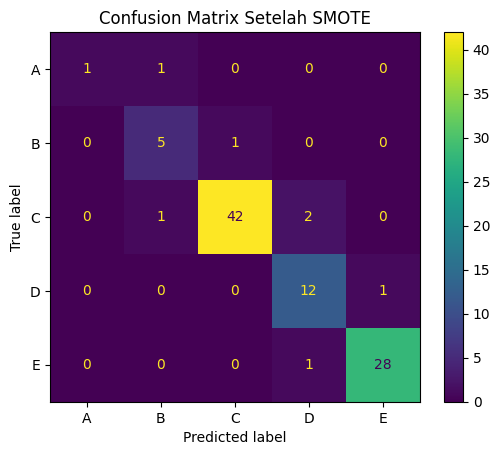

<Figure size 1000x500 with 0 Axes>

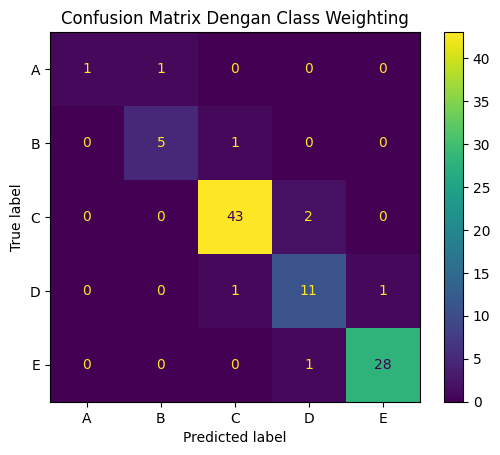

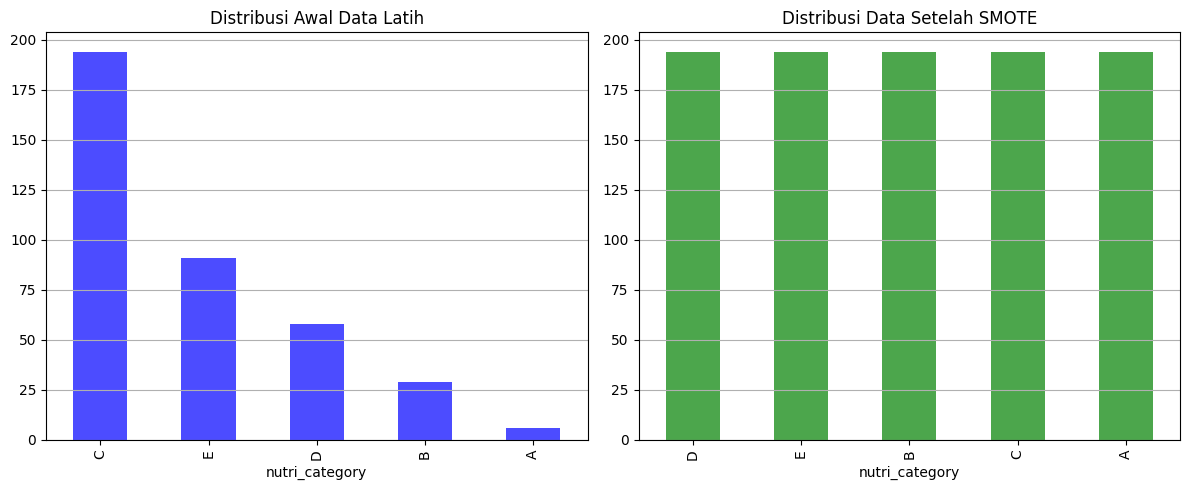

In [30]:
# Evaluasi model
print("\nAccuracy Setelah SMOTE:")
print(accuracy_score(y_test, y_pred_smote))
print("\nClassification Report Setelah SMOTE:")
print(classification_report(y_test, y_pred_smote))

print("\nAccuracy Dengan Class Weighting:")
print(accuracy_score(y_test, y_pred_weighted))
print("\nClassification Report Dengan Class Weighting:")
print(classification_report(y_test, y_pred_weighted))

# Visualisasi Confusion Matrix
plt.figure(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_smote, display_labels=['A', 'B', 'C', 'D', 'E'])
plt.title("Confusion Matrix Setelah SMOTE")
plt.grid(False)
plt.show()

plt.figure(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_weighted, display_labels=['A', 'B', 'C', 'D', 'E'])
plt.title("Confusion Matrix Dengan Class Weighting")
plt.grid(False)
plt.show()

# Plot distribusi target
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title="Distribusi Awal Data Latih", color='blue', alpha=0.7)
plt.grid(axis='y')
plt.subplot(1, 2, 2)
y_train_resampled.value_counts().plot(kind='bar', title="Distribusi Data Setelah SMOTE", color='green', alpha=0.7)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [31]:
from sklearn.model_selection import GridSearchCV

# Parameter grid untuk optimasi
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# GridSearch untuk model dengan SMOTE
grid_smote = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_smote.fit(X_train_resampled, y_train_resampled)

print("Best Hyperparameters (SMOTE):", grid_smote.best_params_)
print("Best Cross-Validated Accuracy (SMOTE):", grid_smote.best_score_)

# GridSearch untuk model dengan Class Weighting
grid_weighted = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_weighted.fit(X_train_final, y_train)

print("Best Hyperparameters (Class Weighting):", grid_weighted.best_params_)
print("Best Cross-Validated Accuracy (Class Weighting):", grid_weighted.best_score_)


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters (SMOTE): {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validated Accuracy (SMOTE): 0.9907248149422211
Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters (Class Weighting): {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validated Accuracy (Class Weighting): 0.9259259259259259


Accuracy (SMOTE - Best Params): 0.8947368421052632

Classification Report (SMOTE - Best Params):
              precision    recall  f1-score   support

           A       1.00      0.50      0.67         2
           B       0.67      0.67      0.67         6
           C       0.95      0.89      0.92        45
           D       0.71      0.92      0.80        13
           E       0.97      0.97      0.97        29

    accuracy                           0.89        95
   macro avg       0.86      0.79      0.80        95
weighted avg       0.91      0.89      0.90        95



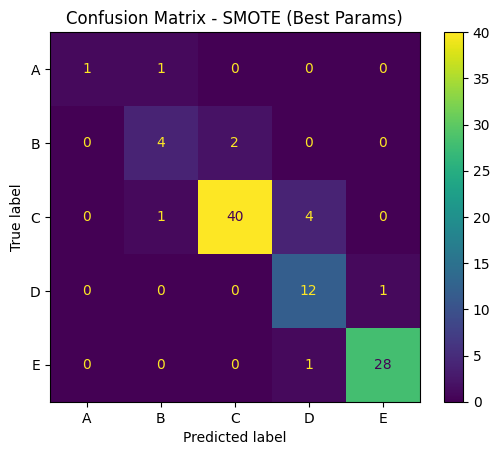

In [42]:
# Model dengan Hyperparameter Terbaik dari GridSearchCV
best_rf_smote = RandomForestClassifier(
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

# Melatih model dengan data oversample (SMOTE)
best_rf_smote.fit(X_train_resampled, y_train_resampled)

# Prediksi pada data uji
y_pred_best_smote = best_rf_smote.predict(X_test_final)

# Evaluasi performa
accuracy_best_smote = accuracy_score(y_test, y_pred_best_smote)
print(f"Accuracy (SMOTE - Best Params): {accuracy_best_smote}")
print("\nClassification Report (SMOTE - Best Params):")
print(classification_report(y_test, y_pred_best_smote))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_smote, display_labels=['A', 'B', 'C', 'D', 'E'])
plt.title("Confusion Matrix - SMOTE (Best Params)")
plt.grid(False)
plt.show()